This notebook includes Aaron's attempts at EDA, feature selection/reduction, and initial attempts at trying a couple of different predictive regression models (including hyperparameter tuning)

The outline:

1. Import the data. These include the accelerometer predictors. We should consider doing a separate analysis without these variables, since relatively few participants have these data
2. Remove a couple of variables we won't be using, including:
    * id
    * ID
    * BIA-BIA_BMI (since we already have a BMI variable as part of the physical group)
    * PCIAT-PCIAT_01 through 20
    * FitnessGram Zone variables that were used to compute the Zone Total (i.e., CU, PU, SRL, SRR, TL) *Note - not entirely sure if we should be doing this*
3. Examining correlations between each predictor (individually) and 
    * PCIAT-PCIAT_Total
    * log(PCIAT-PCIAT_Total)
    * (PCIAT-PCIAT_Total)^2
4. Examining NaN counts for all variables and, potentially, removing variables that:
    * Have very large NaN counts AND
    * Don't have face value as predictors AND
    * Have low correlations with the outcome variable
5. Examining correlations between all predictors and, potentially, removing variables that have extremely high (>0.9) correlation
6. Create sets of predictors grouped by predictors with NaNs in common (e.g., a set where a participant is likely to either have values for all of the predictors in the set or none of the predictors in the set)
7. Exploring interactions between Seasons and associated predictors:
    1. For each predictor that is associated with a Season variable (e.g., within the Physical variables), make a scatterplot of the predictor vs. outcome and display regression lines by Season
    2. If there aren't any clear interactions, removing the Season variable from the list of predictors
    3. If there do appear to be interactions, creating dummy variables from the Season variable
8. Exploring the potential to remove sets of predictors to find a balance between number of predictors and number of participants with data. A regression model needs to have values for all predictors, so if a participant is missing a value for one predictor, we have to remove them from the modeling and predicting process. We don’t have many participants who have values for *all* predictors, but if there are some sets of predictors that don’t contribute significantly to the predictive power, we can remove that set of predictors and, then, include all the participants who were missing values for those predictors
9. Create a linear regression model using a greedy algorithm from the "bottom up"
    1. Make a list of all numerical predictors and also a new empty data frame with 100(?) rows and the predictors as variables
    2. Randomly select a predictor from the list and create a linear model
    3. Randomly select a second predictor from the list and add it to the model
    4. Perform an F test to see if the new model is significantly better than the old
    5. Repeat until the F test is no longer significant
    6. Record the predictors that are in the model in the newly-created data frame
    7. Repeat the above steps 100 (??) times
    8. Compute the mean for each predictor in the data frame. This should give some sense of the "importance" of each predictor
10. Repeat the previous method but using a "top down" algorithm, starting with a full model and removing predictors one-by-one
11. *Maybe* Trying to use PCA and either linear or KNN regression to see if it appears to improve prediction
    * PCA on the entire set of predictors
    * On each set of grouped predictors
12. Using RandomForest Regression on the entire set of predictors and examining the importance matrix to try to find a potential list of predictors
13. *Maybe* using XGBoost to do stuff. (Need to learn what this is)
14. Removing highly-correlated predictors and using LASSO and using LASSO regression (with hyperparameter tuning) to identify important predictors
15. Comparing the apparent predictive power of all the previous methods. If none stand out, then stick with linear regression(?)
16. Start to engage more formally with the modeling process, using Kfold splits

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the original data set
train_cleaned = pd.read_csv('train_cleaned.csv')

In [3]:
# Remove some variables we won't need

# Remove the variables 'id', 'BIA-BIA_BMI'
train_cleaned = train_cleaned.drop(['id', 'BIA-BIA_BMI'], axis=1)

# Remove the PCIAT component variables
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.startswith('PCIAT-PCIAT_0')]
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.startswith('PCIAT-PCIAT_1')]
train_cleaned = train_cleaned.drop(['PCIAT-PCIAT_20'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRR_Zone, and FGC-FGC_TL_Zone
train_cleaned = train_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone'], axis=1)

# Remove the BIA-BIA_ECW, BIA-BIA_ICW, BIA-BIA_FFM, BIA-BIA_LST, and BIA-BIA_TBW variables (based on previous exploration)
train_cleaned = train_cleaned.drop(['BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM', 'BIA-BIA_LST', 'BIA-BIA_TBW', 'BIA-BIA_LDM', 'BIA-BIA_SMM', 'BIA-BIA_FFMI', 'BIA-BIA_FFM', 'BIA-BIA_FMI'], axis=1)

# Remove the SDS-SDS_Total_T variable (based on previous exploration)
train_cleaned = train_cleaned.drop(['SDS-SDS_Total_T'], axis=1)

# Remove the Fitness_Endurance-Max_Stage variable (based on previous exploration)
train_cleaned = train_cleaned.drop(['Fitness_Endurance-Max_Stage'], axis=1)

# Remove the FGC-FGC_SRR and FGC-FGC_SRR_Zone variables (based on previous exploration)
train_cleaned = train_cleaned.drop(['FGC-FGC_SRR'], axis=1)

In [4]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['sii', 'PCIAT-PCIAT_Total'])

In [232]:
# Compute absolute values of correlations between each predictor in numeric_features and PCIAT-PCIAT_Total
correlations = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['PCIAT-PCIAT_Total'])))

# Order correlations from largest to smallest
correlations = correlations.sort_values(ascending=False)

correlations.head(10)

Physical-Height                           0.418307
Basic_Demos-Age                           0.413493
PreInt_EduHx-computerinternet_hoursday    0.379375
Physical-Weight                           0.367770
BIA-BIA_BMR                               0.330358
Physical-Waist_Circumference              0.320012
BIA-BIA_DEE                               0.312847
FGC-FGC_CU                                0.308339
BIA-BIA_Fat                               0.280060
ENMO_Avg_Active_Days_MVPA110              0.264020
dtype: float64

Height, age, and weight are among the strong(er) predictors of the PCIAT_Total outcome.

There appear to be a constellation of BIA variables that are predictors, but prior exploration suggests that these might be strongly correlated with height and weight (and maybe age), so they might be candidates for elimination.

It's possible that there are some non-linear associations. So we'll compute log and ^2 of the outcome variable and re-compute correlations

In [233]:
# Create a new variable that is log(PCIAT-PCIAT_Total)
train_cleaned['log_PCIAT-PCIAT_Total'] = np.log(train_cleaned['PCIAT-PCIAT_Total'])

# Replace -inf values in log_PCIAT-PCIAT_Total with -1
train_cleaned['log_PCIAT-PCIAT_Total'] = train_cleaned['log_PCIAT-PCIAT_Total'].replace(-np.inf, -1)

# Compute absolute values of correlations between each predictor in numeric_features and log_PCIAT-PCIAT_Total
correlations_log = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['log_PCIAT-PCIAT_Total'])))
correlations_log = correlations_log.sort_values(ascending=False)

correlations_log.head(10)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Physical-Height                           0.371769
Basic_Demos-Age                           0.361570
PreInt_EduHx-computerinternet_hoursday    0.313368
Physical-Weight                           0.308019
FGC-FGC_CU                                0.274658
BIA-BIA_BMR                               0.267440
Physical-Waist_Circumference              0.266843
BIA-BIA_DEE                               0.258060
BIA-BIA_Fat                               0.225811
ENMO_Avg_Active_Days_MVPA110              0.213463
dtype: float64

The ordering of these variables is roughly unchanged, but the correlation values have decreased. So it doesn't seem to be the case that any of the predictors have a strong(er) correlation with log(PCIAT_Total)

In [234]:
# Create a new variable that is (PCIAT-PCIAT_Total)^2
train_cleaned['squared_PCIAT-PCIAT_Total'] = train_cleaned['PCIAT-PCIAT_Total']**2

# Compute absolute values of correlations between each predictor in numeric_features and squared_PCIAT-PCIAT_Total
correlations_squared = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['squared_PCIAT-PCIAT_Total'])))
correlations_squared = correlations_squared.sort_values(ascending=False)
correlations_squared.head(10)

Basic_Demos-Age                           0.380519
Physical-Height                           0.377620
Physical-Weight                           0.350157
PreInt_EduHx-computerinternet_hoursday    0.349693
BIA-BIA_BMR                               0.314501
BIA-BIA_DEE                               0.300483
BIA-BIA_Fat                               0.274608
FGC-FGC_CU                                0.268240
Physical-Waist_Circumference              0.267085
Physical-BMI                              0.244743
dtype: float64

Same results for the square relationship as with log. So we'll stick with examining linear relationships. We can remove the newly-created log/square predictors

In [235]:
# Remove the log_PCIAT-PCIAT_Total and squared_PCIAT-PCIAT_Total variables
train_cleaned = train_cleaned.drop(['log_PCIAT-PCIAT_Total', 'squared_PCIAT-PCIAT_Total'], axis=1)

In [237]:
# List the number of NaN values for each variable
train_cleaned.isnull().sum().sort_values(ascending=False).head(20)

Fitness_Endurance_Total_Time_Sec    2562
Physical-Waist_Circumference        2473
ENMO_Avg_Active_Days_MVPA192        2372
ENMO_Avg_Active_Days_MVPA110        2372
Positive_Anglez_Active_Days         2372
FGC-FGC_GSD_Zone                    2329
FGC-FGC_GSND_Zone                   2328
FGC-FGC_GSND                        2322
FGC-FGC_GSD                         2321
Fitness_Endurance-Season            2108
BIA-BIA_Fat                         1602
BIA-BIA_BMC                         1601
BIA-BIA_DEE                         1576
BIA-BIA_BMR                         1576
BIA-BIA_Activity_Level_num          1575
BIA-BIA_Frame_num                   1575
BIA-Season                          1456
PAQ_MVPA                            1414
PAQ_Total                           1414
PAQ_Season                          1414
dtype: int64

There are some variables with a *lot* of missing information. But maybe the distribution (among participants) of number of NaN values is bimodal - perhaps there are a lot of people who are missing data for most of the variables.

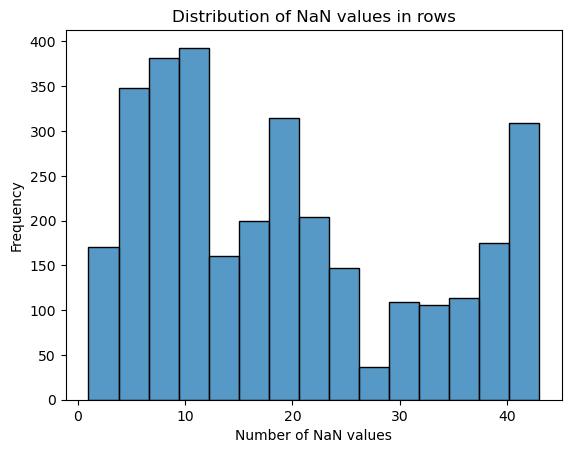

In [238]:
# Count the number of NaN values for each row and create a histogram of the distribution of these values
train_cleaned['NaN_count'] = train_cleaned.isnull().sum(axis=1)
sns.histplot(train_cleaned['NaN_count'])
plt.xlabel('Number of NaN values')
plt.ylabel('Frequency')
plt.title('Distribution of NaN values in rows')
plt.show()

The distribution looks multimodal. There are ~350 people who are missing data for nearly all of the variables, a group who are missing data for a few, and then no other groups that really stand out

These numbers are probably affected by the grouping into Physical, FitnessGram, and BIA—it seems likely that individuals would either have data for all of the predictors in a category or none of the predictors.

Doing regression requires values for all predictors. So we'll need to do one of the following: 
1. Focus on the ~300 participants who have data for (nearly) all of the variables, 
2. Focus only on the variables for which all participants have data
3. Some balance between these options -- eliminate a small number of high-NaN variables and then eliminate participants with NaN values in the remaining variables.

Big question: What should our target sample size be for running the regression?

Let's get a sense of how many independent features there really are. We'll figure out whether the Physical, FGC, and BIA variables tend to all be missing together. The goal is to create sets of variables that are all either present or not. We can then include these sets (or not) in various prediction methods.

The sets below were created by initially grouping variables by label (e.g., all variables that started with 'Physical'), then looking at the distribution of NaN counts. Bimodality in the distribution indicated that participants either had data for all of the variables in the group or had data for none of the variables in the group. If the distribution had more than two modes, the set was split into subsets that were bimodal 

In [12]:
# Create a list of all columns for each "group" of variables

physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
physical_features = physical_features.drop('Physical-Waist_Circumference')

physical_features_waist = ['Physical-Waist_Circumference']

FGC_GS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC-FGC_GS') & train_cleaned.columns.isin(numeric_features)]

FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
FGC_features = FGC_features.append(pd.Index(['FitnessGram_Zone_Total']))
FGC_features = FGC_features.drop(FGC_GS_features)

BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]

PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]

SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]

fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]

Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]

ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']

PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


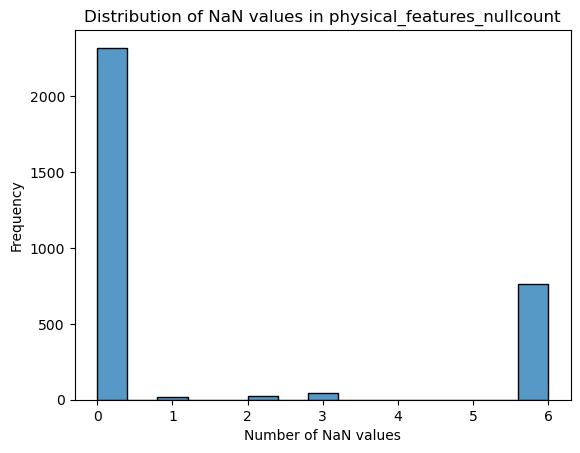

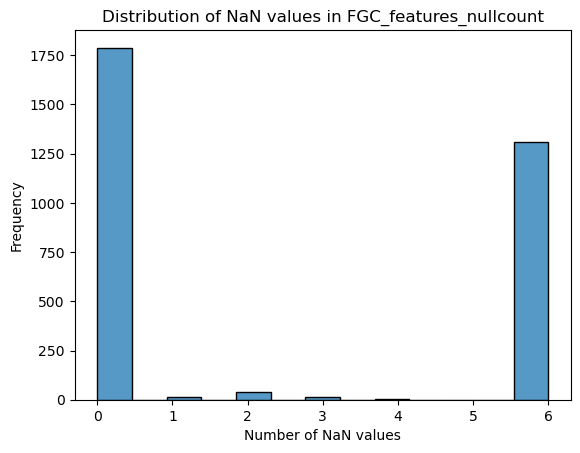

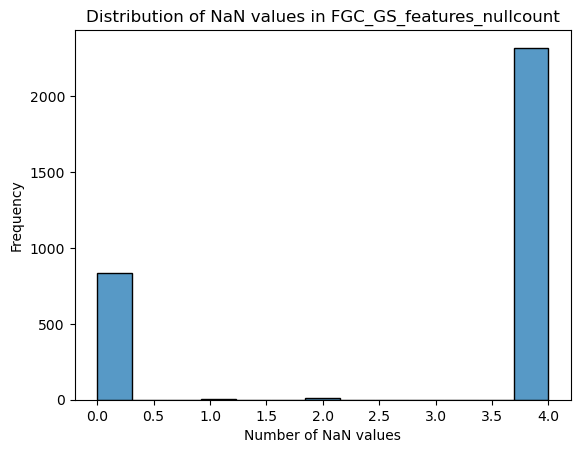

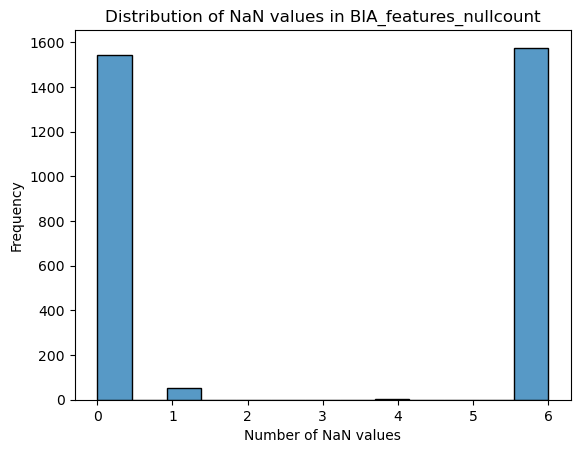

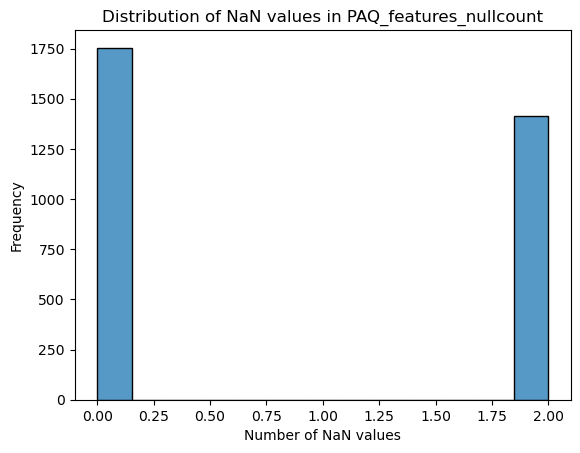

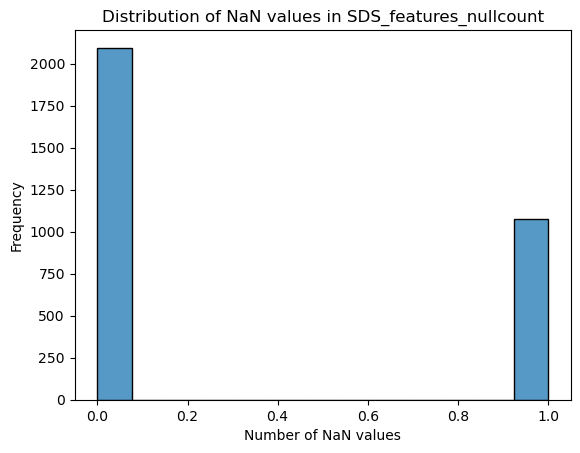

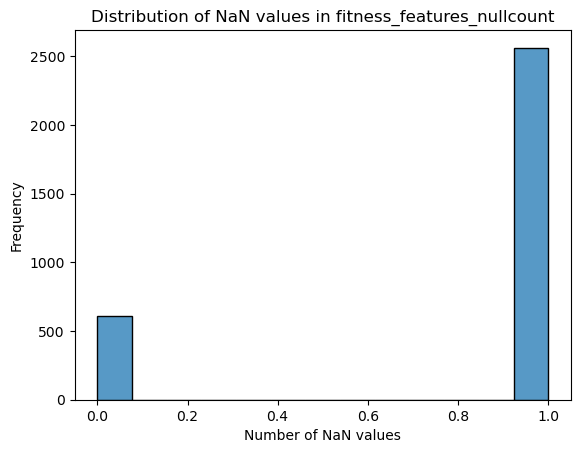

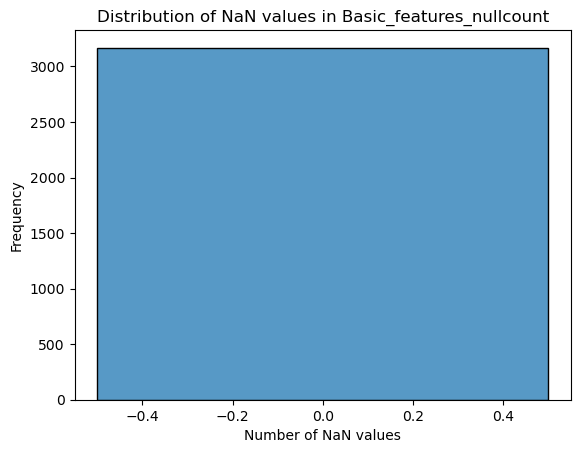

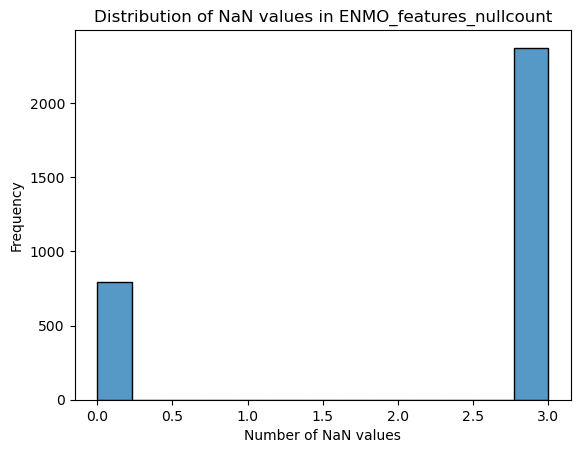

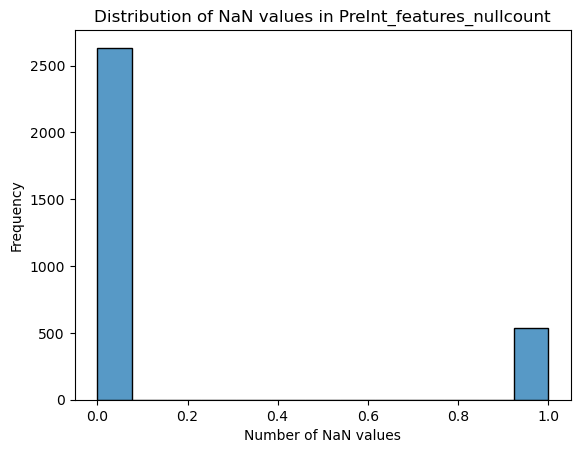

In [241]:
# Create a new variable that counts the number of NaN values among variables in the physical_features list
train_cleaned['physical_features_nullcount'] = train_cleaned[physical_features].isnull().sum(axis=1)
train_cleaned['FGC_features_nullcount'] = train_cleaned[FGC_features].isnull().sum(axis=1)
train_cleaned['FGC_GS_features_nullcount'] = train_cleaned[FGC_GS_features].isnull().sum(axis=1)
train_cleaned['BIA_features_nullcount'] = train_cleaned[BIA_features].isnull().sum(axis=1)
train_cleaned['PAQ_features_nullcount'] = train_cleaned[PAQ_features].isnull().sum(axis=1)
train_cleaned['SDS_features_nullcount'] = train_cleaned[SDS_features].isnull().sum(axis=1)
train_cleaned['fitness_features_nullcount'] = train_cleaned[fitness_features].isnull().sum(axis=1)
train_cleaned['Basic_features_nullcount'] = train_cleaned[Basic_features].isnull().sum(axis=1)
train_cleaned['ENMO_features_nullcount'] = train_cleaned[ENMO_features].isnull().sum(axis=1)
train_cleaned['PreInt_features_nullcount'] = train_cleaned[PreInt_features].isnull().sum(axis=1)

# Make a set of histograms for each variable that ends in '_nullcount'
for feature in train_cleaned.columns:
    if feature.endswith('_nullcount'):
        sns.histplot(train_cleaned[feature])
        plt.xlabel('Number of NaN values')
        plt.ylabel('Frequency')
        plt.title('Distribution of NaN values in ' + feature)
        plt.show()

In [ ]:
# Remove variables from train_cleaned that end with _nullcount
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.endswith('_nullcount')]

# Remove the NaN_Count variable from train_cleaned
train_cleaned = train_cleaned.drop('NaN_count', axis=1)

Next, we'll examine correlations between predictors. The goal is to, potentially, eliminate some predictors that are highly correlated.

In [244]:
# Compute absolute value of correlation between variables in numeric_features
correlation_matrix = train_cleaned[numeric_features].corr().abs()

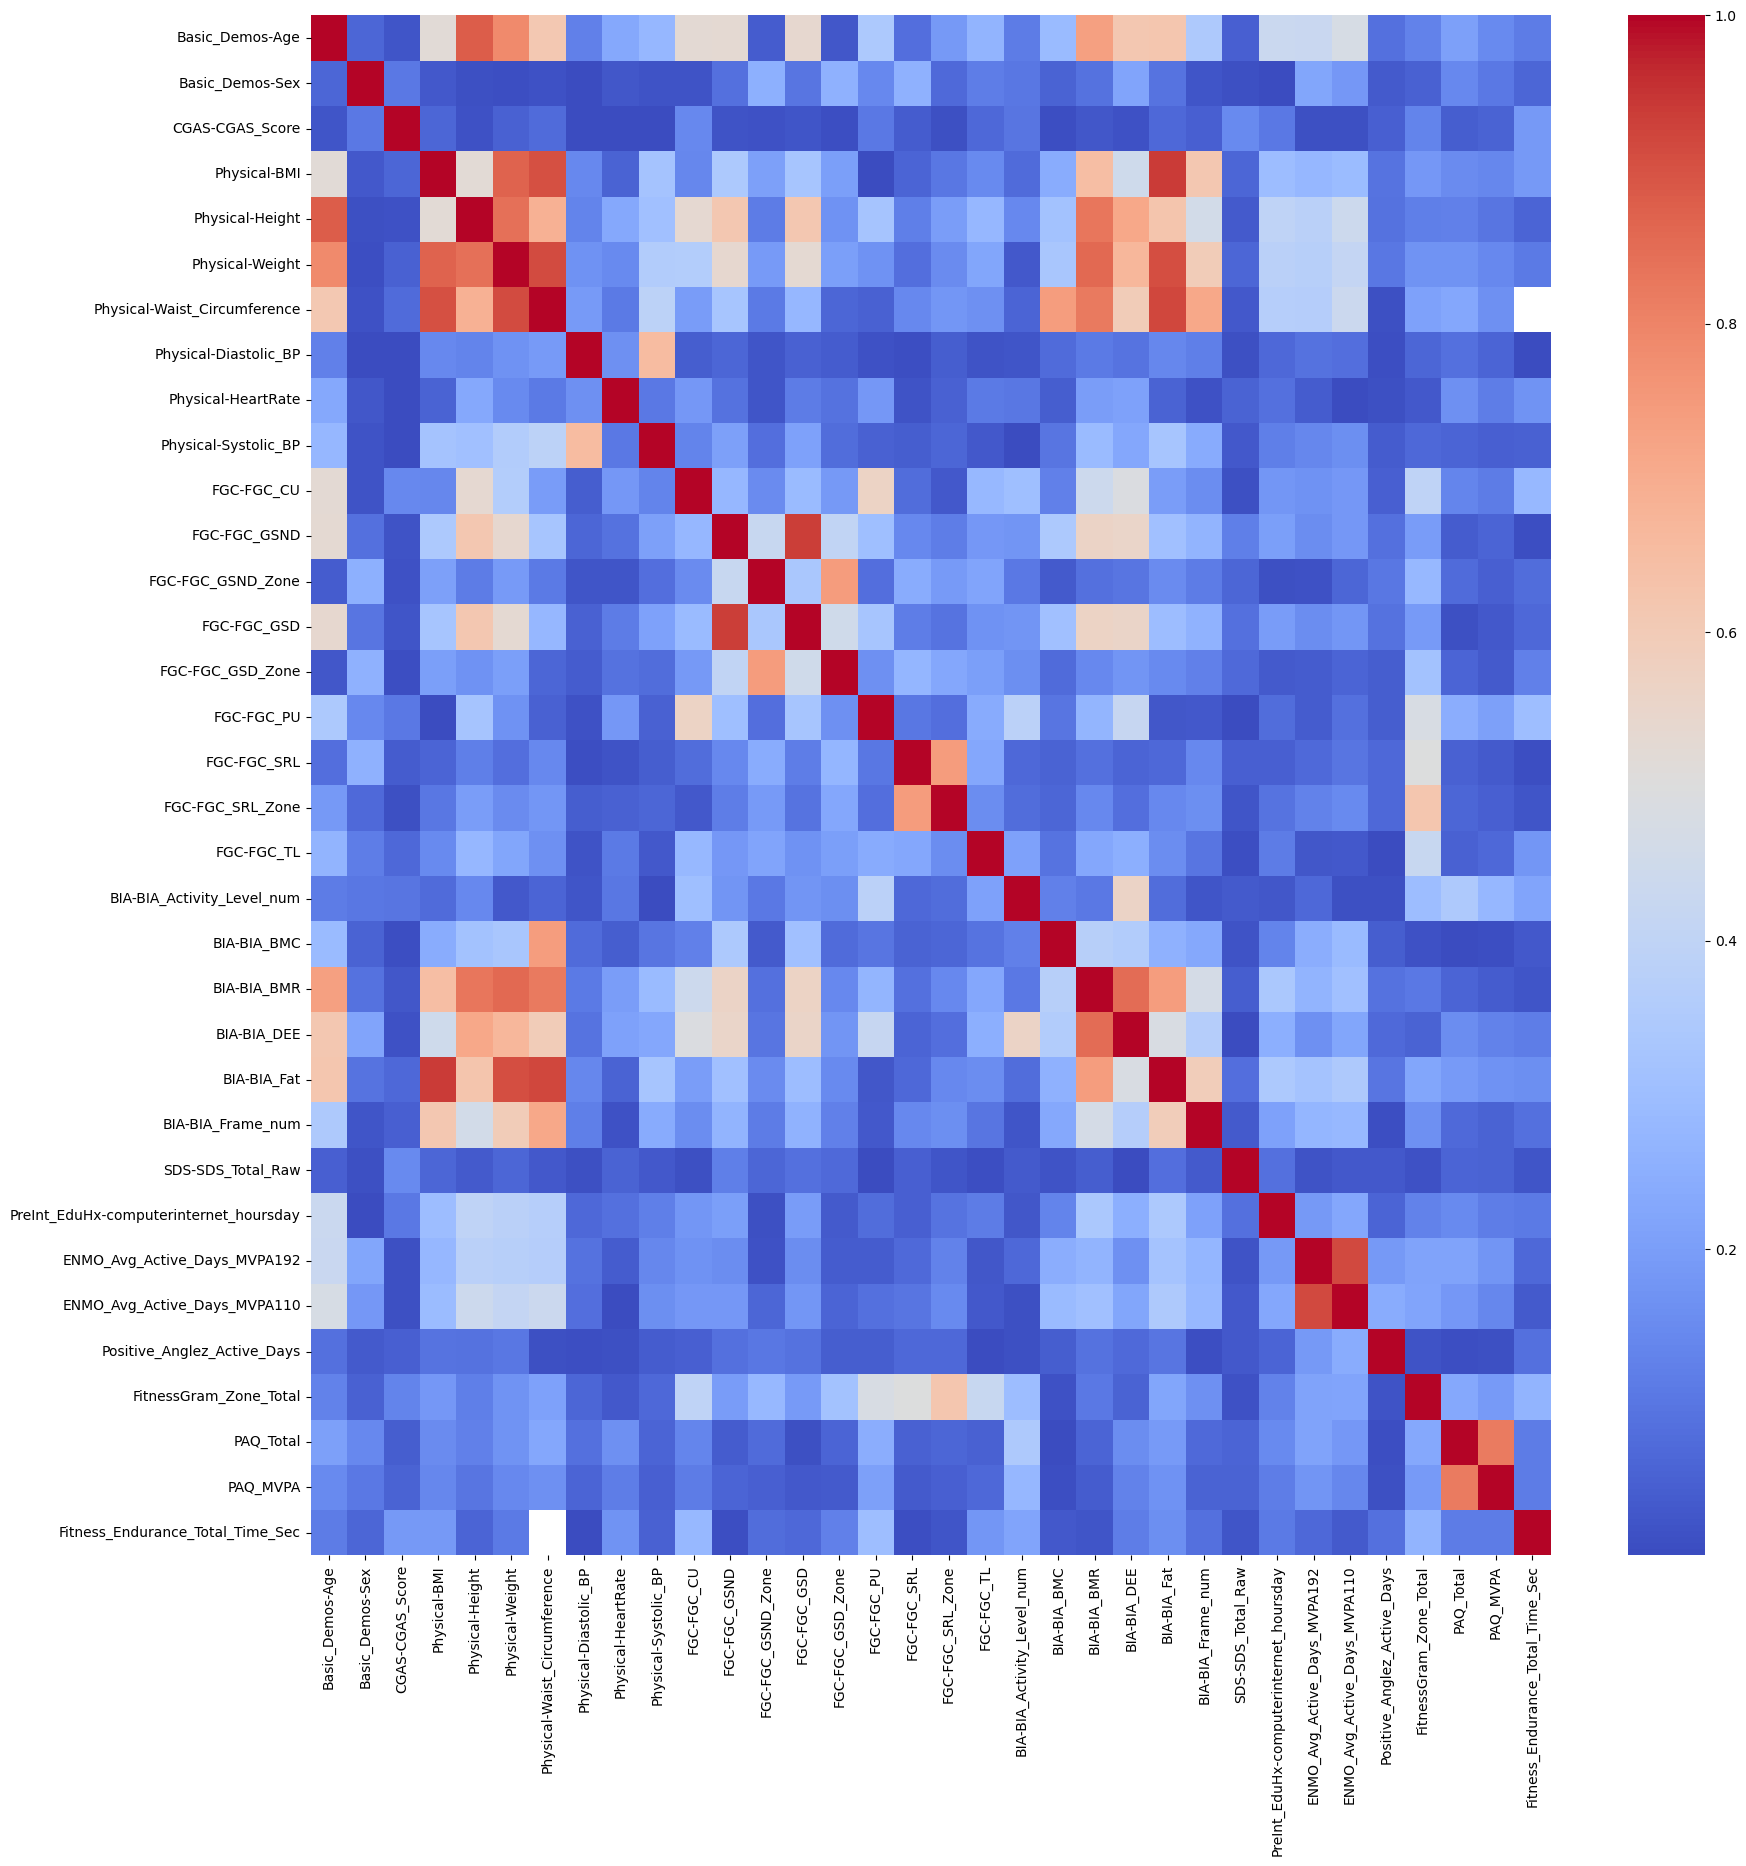

In [245]:
# Create a 20x20 heatmap of correlation_matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [246]:
# List the values in correlation_matrix from largest to smallest, only including values at least 0.85 and less than 1
correlation_matrix = correlation_matrix.unstack()
correlation_matrix = correlation_matrix.sort_values(ascending=False)
correlation_matrix = correlation_matrix[correlation_matrix != 1]
correlation_matrix = correlation_matrix[correlation_matrix >= 0.9]

# Show all values in correlation_matrix without truncating output
pd.set_option('display.max_rows', None)
correlation_matrix

BIA-BIA_Fat                   Physical-BMI                    0.938172
Physical-BMI                  BIA-BIA_Fat                     0.938172
FGC-FGC_GSND                  FGC-FGC_GSD                     0.934157
FGC-FGC_GSD                   FGC-FGC_GSND                    0.934157
BIA-BIA_Fat                   Physical-Waist_Circumference    0.918402
Physical-Waist_Circumference  BIA-BIA_Fat                     0.918402
ENMO_Avg_Active_Days_MVPA110  ENMO_Avg_Active_Days_MVPA192    0.917565
ENMO_Avg_Active_Days_MVPA192  ENMO_Avg_Active_Days_MVPA110    0.917565
Physical-Waist_Circumference  Physical-Weight                 0.912098
Physical-Weight               Physical-Waist_Circumference    0.912098
BIA-BIA_Fat                   Physical-Weight                 0.906519
Physical-Weight               BIA-BIA_Fat                     0.906519
Physical-BMI                  Physical-Waist_Circumference    0.904252
Physical-Waist_Circumference  Physical-BMI                    0.904252
dtype:

Some of these predictos are highly correlated. 

* BMI Variables
    * Basal metabolic rate, fat-free mass, lean soft tissue, and total body water are all, essentially, interchangeable
    * BMR also seems to do a good job predicting lean dry mass and skeletal muscle mass
    * Total body water is highly (~98%) correlated with extracellular water and intracellular water
    * If we keep BIA-BIA_BMR (basal metabolic rate) then we can probably just drop BIA-BIA_ECW, BIA-BIA_ICW, BIA-BIA_FFM, BIA-BIA_LST, BIA-BIA_LDM, BIA-BIA_SMM, and BIA-BIA_TBW
    * It turns out that fat-free mass index is a function of FFM, height, and weight, so we can drop FFMI
    * It also seems like if we keep Fat we could drop fat-free mass and fat mass index
* SDS Variables
    * SDS_Total_Raw and SDS_Total_T appear essentially the same, so we could just drop Total_T
* Fitness_Endurance
    * Max_Stage and Total_Time_Sec appear basically the same. And I'm assuming that Max_Stage is a function of Total_Time_Sec. So we could just drop Max_Stage
* FGC
    * Grip strength Non-dominant and Dominant are reasonably correlated, but not quite the same. Maybe keep them for now because they're measuring sort-of fundamentally different things?
    * Sit & reach left vs right - seems like these should really be the same. Even though they're less correlated than others, I'm going to drop SRL

We'll circle back up to the top and drop these, and then re-do the computations.

Next, we'll look for effects of season (within group) as a predictor of PCIAT

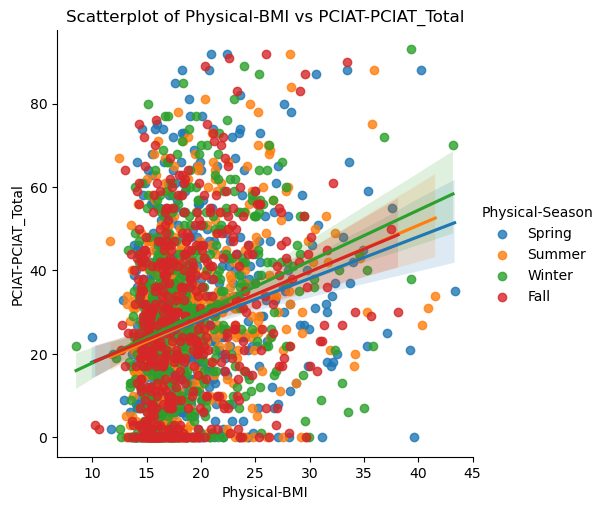

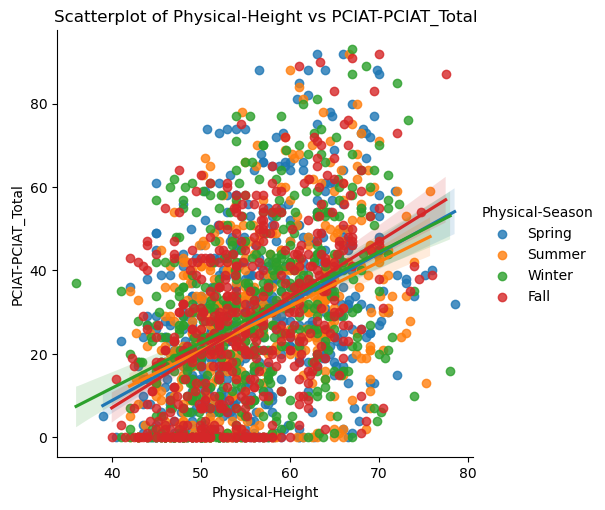

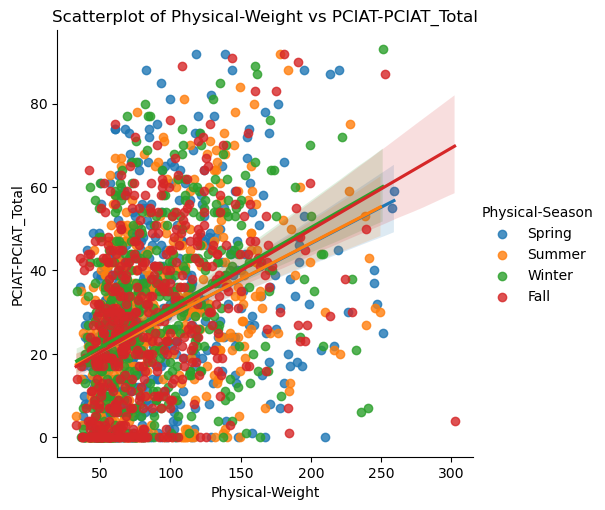

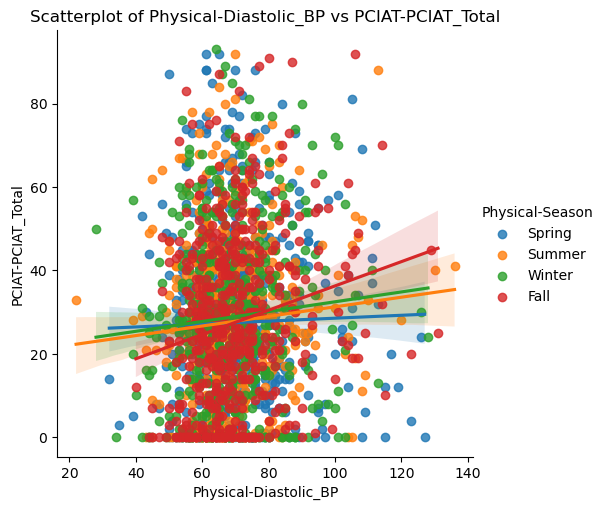

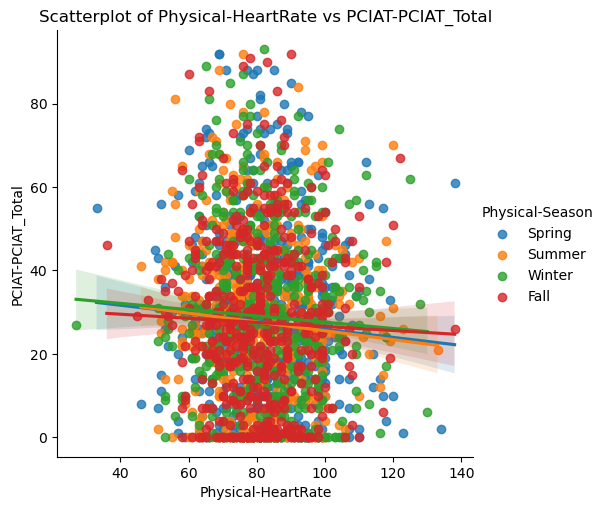

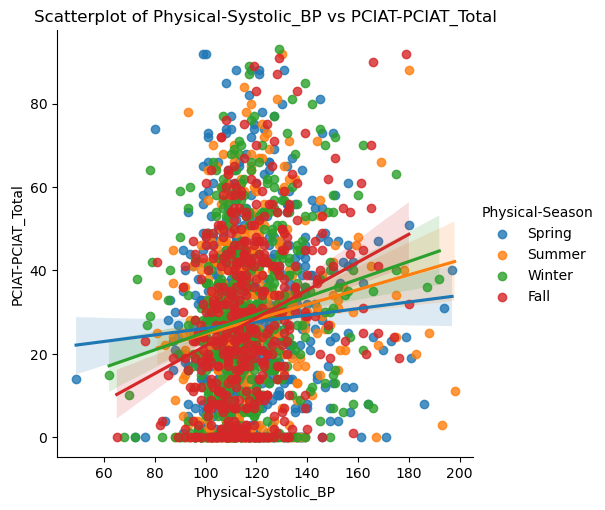

In [152]:
# For each variable in physical_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by Physical-Season. Add a line of best fit for each value of Physical-Season
for feature in physical_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='Physical-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

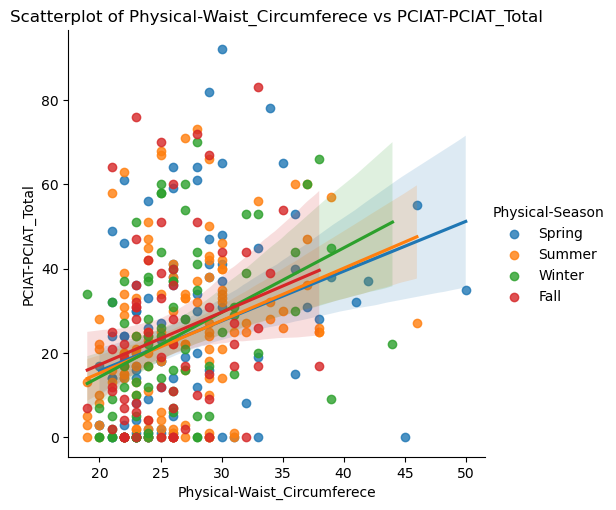

In [155]:
# For each variable in physical_features_waist, make a scatterplot vs PCIAT-PCIAT_Total with points colored by Physical-Season. Add a line of best fit for each value of Physical-Season

sns.lmplot(data=train_cleaned, x='Physical-Waist_Circumference', y='PCIAT-PCIAT_Total', hue='Physical-Season')
plt.xlabel(feature)
plt.ylabel('PCIAT-PCIAT_Total')
plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
plt.show()

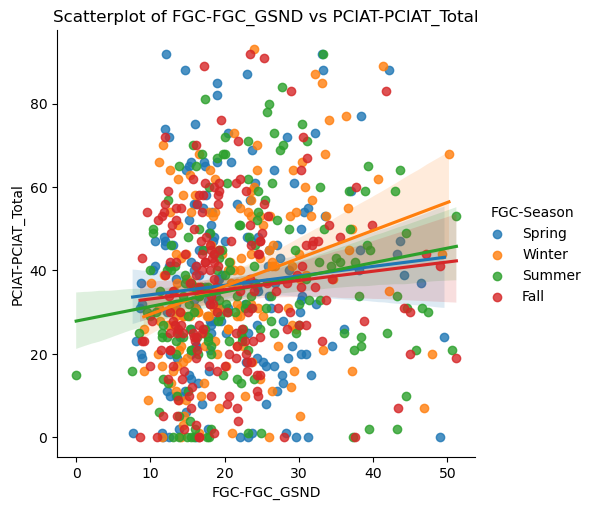

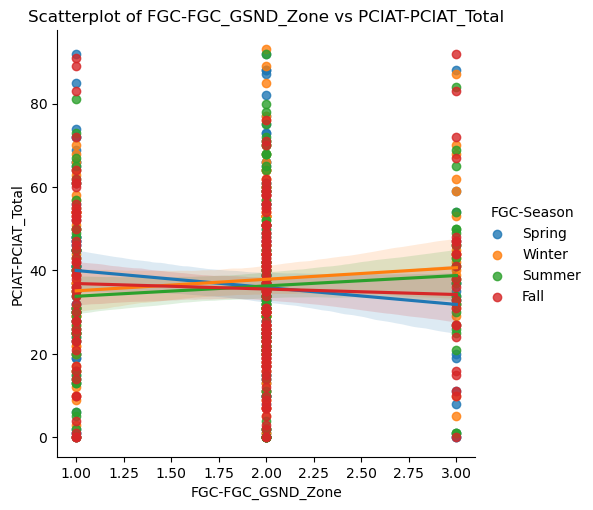

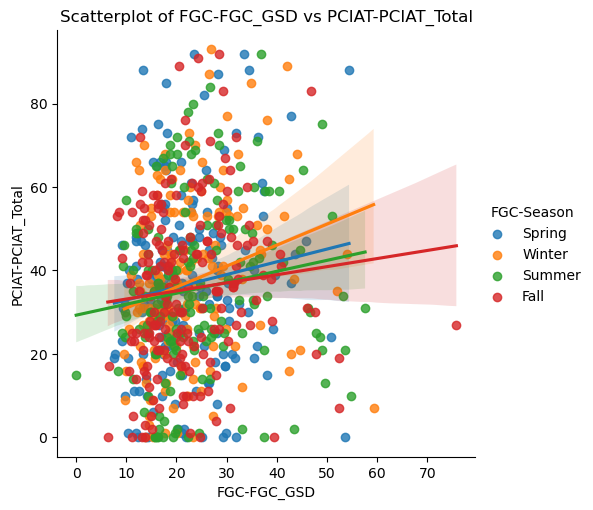

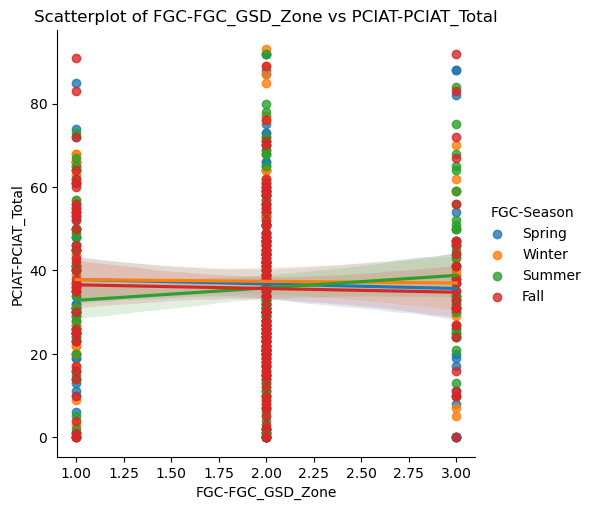

In [ ]:
# For each variable in FGC_GS_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by FGC-Season. Add a line of best fit for each value of FGC-Season
for feature in FGC_GS_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='FGC-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

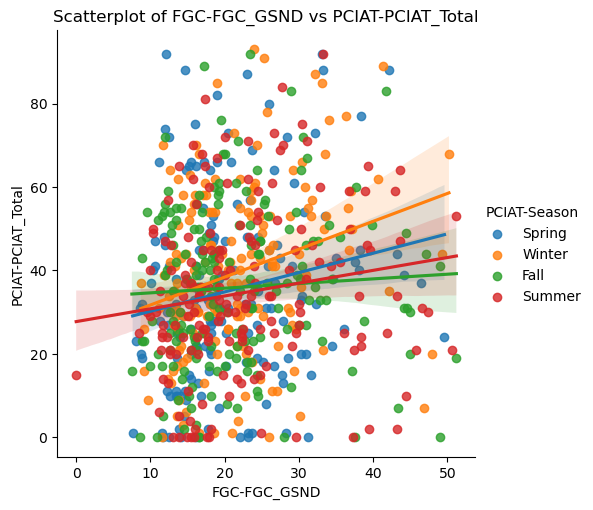

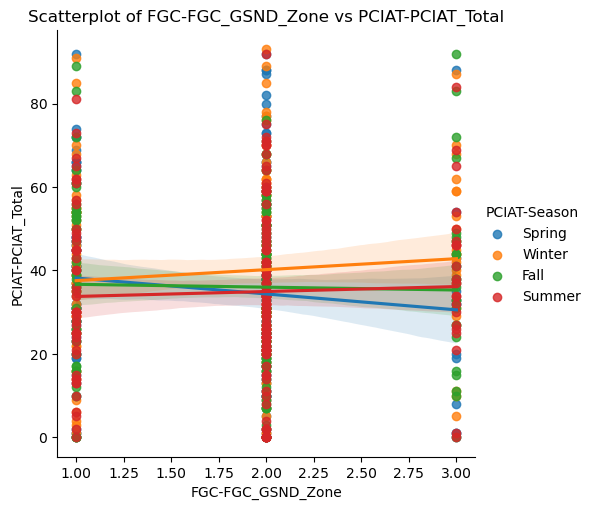

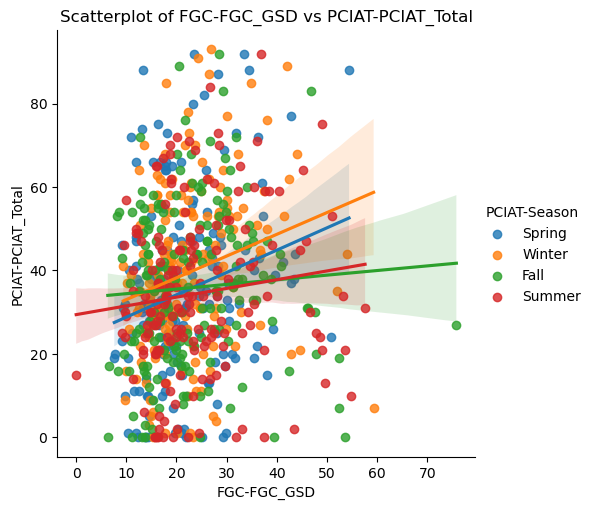

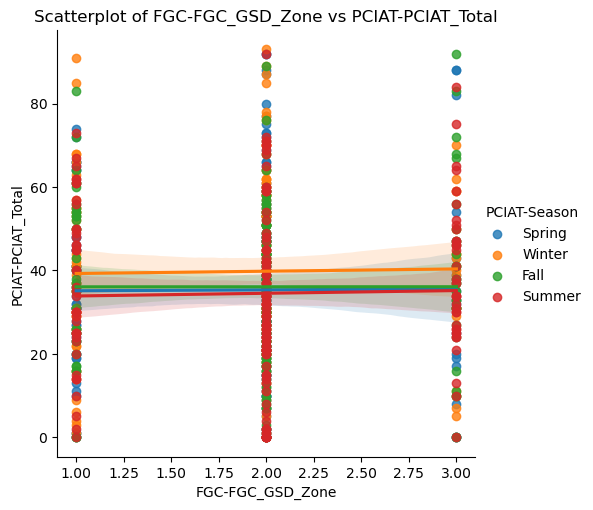

In [160]:
# For each variable in FGC_GS_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by FGC-Season. Add a line of best fit for each value of PCIAT-Season
for feature in FGC_GS_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='PCIAT-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

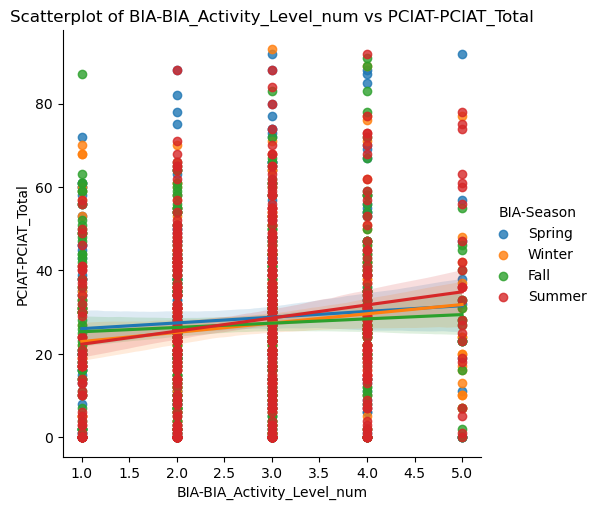

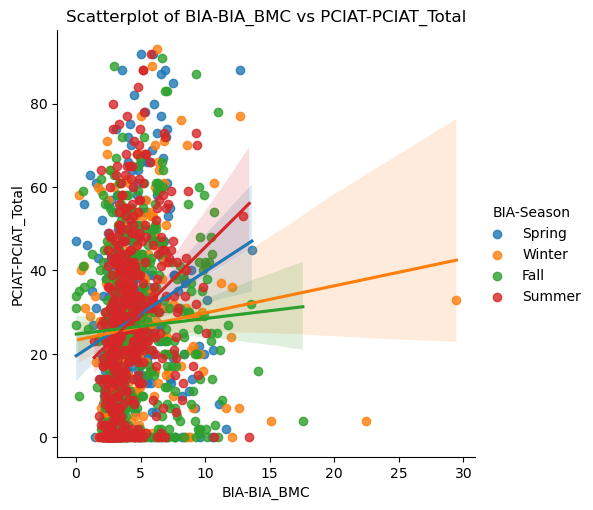

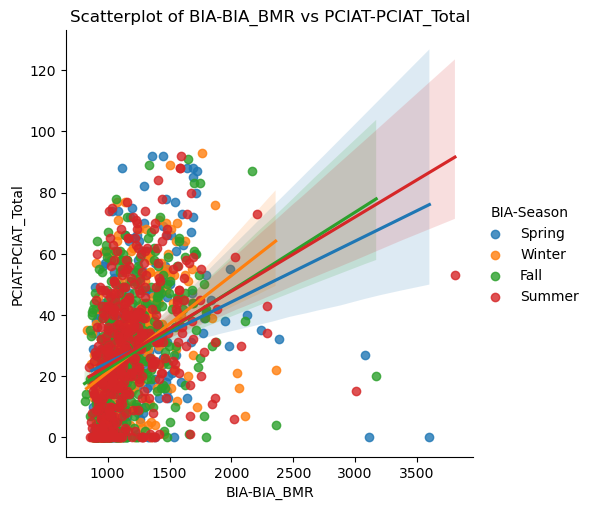

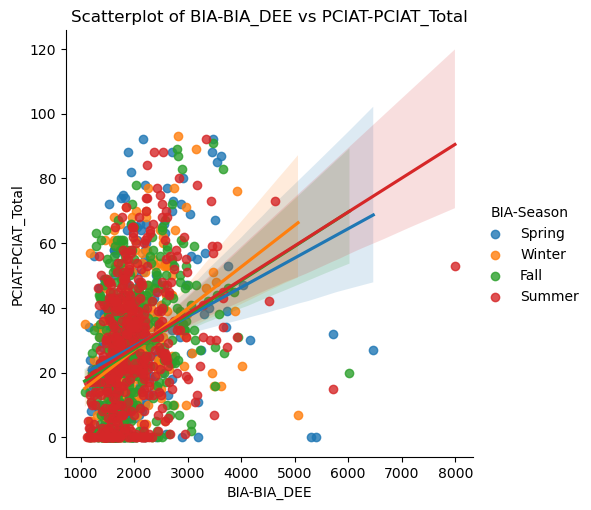

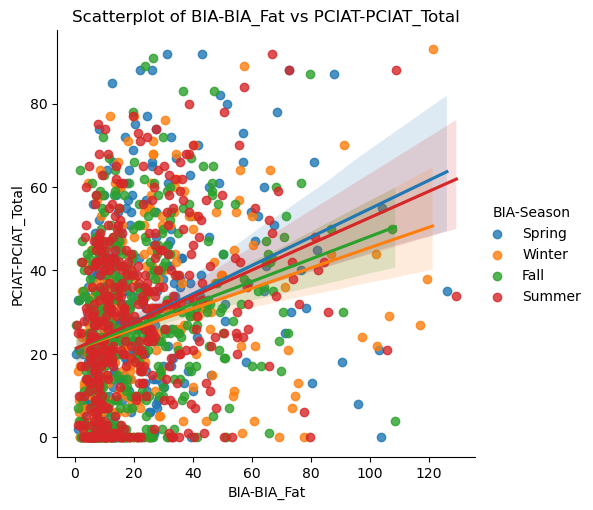

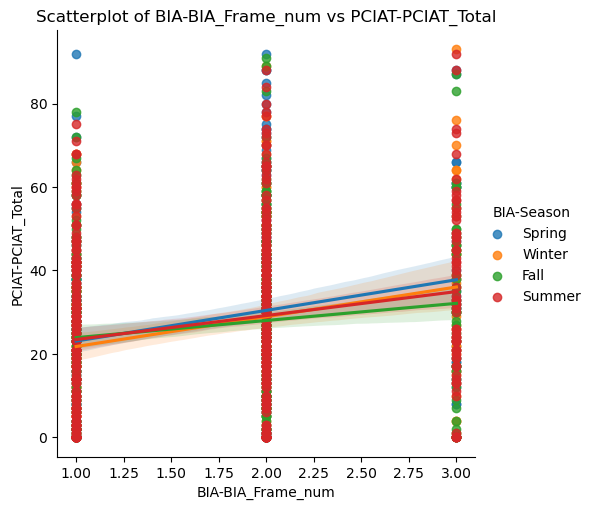

In [157]:
# For each variable in BIA_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by . Add a line of best fit for each value of BIA-Season
for feature in BIA_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='BIA-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

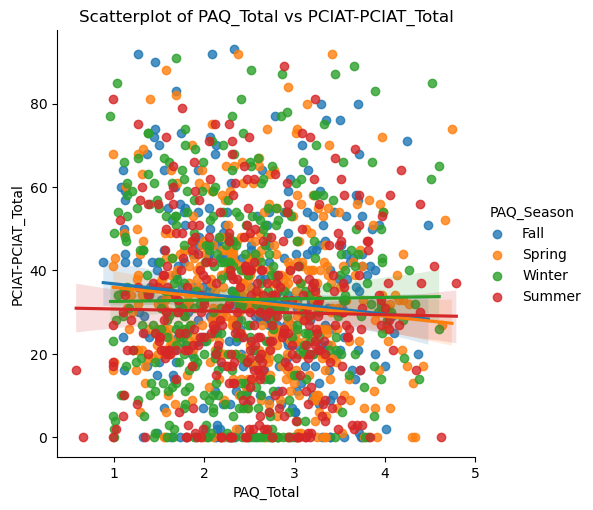

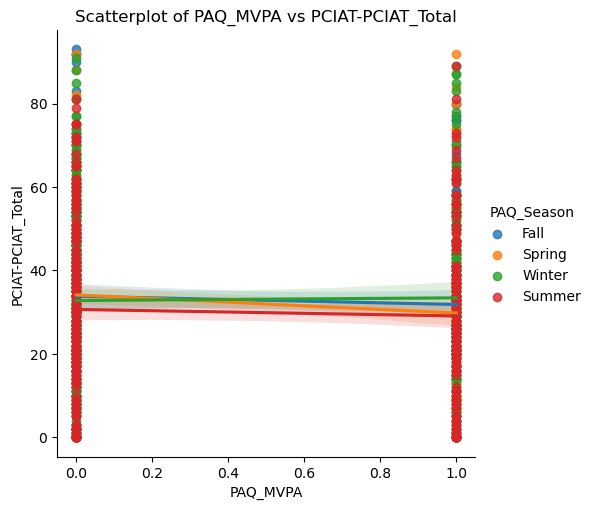

In [159]:
# For each variable in PAQ_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by PAQ-Season. Add a line of best fit for each value of PAQ_Season
for feature in PAQ_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='PAQ_Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

There definitely seem to be some interactions between season and the relationship between various predictor variables and PCIAT scores.

**However**

PCIAT also has a season in which it was collected. It doesn't seem clear which season we should use in the interaction. For now, let's go ahead and disregard season. We can circle back to these variables later if we feel up to it.

Now let's start creating linear models using all combinations of the predictor sets

There are 11 predictor sets, so there will be a total of 2^11=2048 combinations of sets

For each combination, we'll do a 5-fold cross-validation and compute the mean MSE

Then we'll look at the combinations of predictor sets with the lowest mean MSE

The computations seem to be winnowing down the size of the data set more than anticipated, so I'll be inserting some additional code to see where this is happening

In [13]:
# Load all the things we'll need
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# First, split the entire data set into training and testing to use as a final check on the models we build
# Setting a value for random_state to diagnose buggy code
Training_Set, Testing_Set = train_test_split(train_cleaned,
                                                       shuffle = True,
                                                       random_state = 216,
                                                       test_size = .2)

In [14]:
# Count the number of NaN values in PCIAT-PCIAT_Total in train_cleaned, Training_Set, and Testing_Set:
print('Number of total entries in the train_cleaned:', len(train_cleaned))
print('Number of non-NaN entries in the train_cleaned:', len(train_cleaned) - train_cleaned['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Training_Set:', len(Training_Set))
print('Number of non-NaN entries in PCIAT_Total for Training_Set:', len(Training_Set) - Training_Set['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Testing_Set:', len(Testing_Set))
print('Number of non-NaN entries in PCIAT_Total for Testing_Set:', len(Testing_Set) - Testing_Set['PCIAT-PCIAT_Total'].isna().sum())


Number of total entries in the train_cleaned: 3168
Number of non-NaN entries in the train_cleaned: 2195
Number of total entries in the Training_Set: 2534
Number of non-NaN entries in PCIAT_Total for Training_Set: 1742
Number of total entries in the Testing_Set: 634
Number of non-NaN entries in PCIAT_Total for Testing_Set: 453


In [15]:
# Next we'll set up the power set of the groups and create a dataframe to hold the members of the power set and the mean MSE for that collection

# Create a list of all groups of features
groups = [physical_features, physical_features_waist, FGC_GS_features, FGC_features, BIA_features, PAQ_features, SDS_features, fitness_features, Basic_features, ENMO_features, PreInt_features]

# This function returns the power set of a set minus the empty set.  
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

# Create the power set of the groups of features
features_groups_powerset = powerset(groups)

## This is the baseline model
features_groups_powerset.append([['baseline']])

# Each element of the powerset is a list of lists. To extract the features from each list of lists, we'll need to be able to 'flatten' the list of lists into a list
def flatten(inlist):
    flat_list = []
    for element in inlist:
        flat_list.extend(element)
    return flat_list

In [16]:
# Set up a 5-fold split to use with the linear models
num_splits = 5

#Create a numpy array with num_splits columns and len(features_groups_powerset) rows to hold the MSE values
cv_mses = np.zeros((len(features_groups_powerset), num_splits))

#Create a numpy array with len(features_groups_powerset) rows to hold the number of valid observations in each split
cv_sizes = np.zeros((len(features_groups_powerset), num_splits))

#Make a KFold object; setting random_state for now to help diagnose any issues with the code
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)

## loop through all splits
i = 0
for train_index, test_index in kfold.split(Training_Set):
    #print('Iteration:',i)
    ## get train and holdout sets
    problematic_train_train = Training_Set.iloc[train_index]
    problematic_train_holdout = Training_Set.iloc[test_index]

    #loop through all models
    j = 0
    for featureset in features_groups_powerset:
        #print('Featureset:',featureset)
        featureset_flattened = flatten(featureset)
        #print('Featureset Flattened:',featureset_flattened)

        if featureset_flattened == ['baseline']:
            #print('Featureset was baseline')
        
            # Drop NaNs from problematic_train_train for the 'PCIAT-PCIAT_Total' variable
            problematic_train_train_copy = problematic_train_train.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train_copy))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout_copyp))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                problematic_train_train_mean = problematic_train_train_copy['PCIAT-PCIAT_Total'].mean()
                #print('Prediction is:',problematic_train_train_mean)
                predict = problematic_train_train_mean * np.ones(len(problematic_train_holdout_copy))
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else: cv_mses[j,i]=np.nan
        else:
            # Drop NaNs from problematic_train_train where the variables are either in featureset_flattened or are equal to 'PCIAT-PCIAT_Total'
            problematic_train_train_copy = problematic_train_train.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                ## make clone
                reg = LinearRegression(copy_X = True)
            
                ## fit clone
                reg.fit(problematic_train_train_copy[featureset_flattened], problematic_train_train_copy['PCIAT-PCIAT_Total'])
                #print('LinReg has been fit')
                predict = reg.predict(problematic_train_holdout_copy[featureset_flattened])
                #print('LinReg has been predicted')

                # Set the value of feature_combinations where the value of 'predictor_list' is equal to featureset and the column is equal to i
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else:
                cv_mses[j,i] = np.nan
        j=j+1
    i=i+1

In [17]:
# Compute the mean of each row in cv_mses
cv_mses_means = np.mean(cv_mses, axis=1)

# Compute the mean of each row in cv_sizes
cv_sizes_means = np.mean(cv_sizes, axis=1)

# Create a new dataframe where the first column is features_groups_powerset and the second column is cv_mses_means
MSE_Group_Comparison = pd.DataFrame({'featureset': features_groups_powerset, 'Mean_MSE': cv_mses_means, 'Non_NAN_Observations':cv_sizes_means})


In [18]:
# Sort MSE_Group_Comparison from largest to smallest based on Non_NAN_Observations
MSE_Group_Comparison = MSE_Group_Comparison.sort_values(by='Non_NAN_Observations', ascending=False)

MSE_Group_Comparison.head(20)

,featureset,Mean_MSE,Non_NAN_Observations
2047,[[baseline]],413.171758,1742.0
255,"[[Basic_Demos-Age, Basic_Demos-Sex]]",336.001599,1742.0
1279,"[[Basic_Demos-Age, Basic_Demos-Sex], [PreInt_E...",313.903457,1689.0
1023,[[PreInt_EduHx-computerinternet_hoursday]],351.281529,1689.0
63,[[SDS-SDS_Total_Raw]],383.356577,1615.0
319,"[[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...",316.785156,1615.0
1343,"[[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...",296.874168,1566.0
1087,"[[SDS-SDS_Total_Raw], [PreInt_EduHx-computerin...",331.984086,1566.0
256,"[[Physical-BMI, Physical-Height, Physical-Weig...",335.070599,1548.0
0,"[[Physical-BMI, Physical-Height, Physical-Weig...",345.632857,1548.0


In [19]:
# Sort MSE_Group_Comparison from smallest to largest based on Mean_MSE
MSE_Group_Comparison = MSE_Group_Comparison.sort_values(by='Mean_MSE', ascending=True)

MSE_Group_Comparison.head(20)

,featureset,Mean_MSE,Non_NAN_Observations
1527,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",238.084131,219.0
1495,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",243.001698,346.0
1511,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",245.094722,270.0
1487,"[[BIA-BIA_Activity_Level_num, BIA-BIA_BMC, BIA...",246.278746,358.0
1519,"[[BIA-BIA_Activity_Level_num, BIA-BIA_BMC, BIA...",250.493886,224.0
1239,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",250.915283,346.0
1479,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",251.416133,437.0
1463,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",252.058015,219.0
1943,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",253.431095,153.0
1271,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_SRL, FGC-FGC...",255.178638,219.0
